In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

### I am using Apple Silicon, Metal Performance Shaders is used

In [2]:

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# use cuda if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load traces

In [3]:
traces_file = 'traces.csv'
nrows = 5000 # number of traces to use (debug purposes)
batch_size = 512
print('number of traces: ', len(pd.read_csv(traces_file)))
print('number of traces used: ', nrows)

traces = pd.read_csv(traces_file, nrows=nrows)
# Split into train and test
train_data, test_data = train_test_split(traces, test_size=0.25)

# get number of unique values in each column
print('number of unique values to predict: ', traces.nunique()[-1])

number of traces:  3833043
number of traces used:  5000
number of unique values to predict:  25


### Create vocabulary

In [4]:
def load_data(data, batch_size):
    label_encoder_pc = LabelEncoder()
    label_encoder_delta_in = LabelEncoder()
    label_encoder_delta_out = LabelEncoder()

    # Fit label encoder and transform labels into encoded values
    data['pc_encoded'] = label_encoder_pc.fit_transform(data['pc'])
    data['delta_in_encoded'] = label_encoder_delta_in.fit_transform(data['delta_in'])
    data['delta_out_encoded'] = label_encoder_delta_out.fit_transform(data['delta_out'])

    # Convert dataframes to tensors
    pc = torch.tensor(data['pc_encoded'].values)
    delta_in = torch.tensor(data['delta_in_encoded'].values)
    targets = torch.tensor(data['delta_out_encoded'].values)

    # Create a custom Dataset instance
    dataset = TensorDataset(pc, delta_in, targets)

    # Create a DataLoader instance
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Get unique target keys
    target_keys = set(data['delta_out_encoded'].unique())

    return data_loader, len(label_encoder_pc.classes_), len(label_encoder_delta_in.classes_), len(label_encoder_delta_out.classes_), target_keys

train_iter, num_pc, num_delta_in, num_output_next, target_keys = load_data(train_data, batch_size=batch_size)
test_iter, _, _, _, _ = load_data(test_data, batch_size=batch_size)
# add 1 for the next delta which is not in the training set
num_pc += 1
num_delta_in += 1
num_output_next += 1

print('number of unique pc: ', num_pc)
print('number of unique input delta: ', num_delta_in)
print('number of unique output delta: ', num_output_next)


number of unique pc:  168
number of unique input delta:  24
number of unique output delta:  23


### Define LSTM model

In [5]:
class EmbeddingLSTM(nn.Module):
    def __init__(self, num_pc, num_delta_in, num_output_next, embed_dim, hidden_dim, topPredNum, num_layers, dropout):
        # Layer structure is described in the paper
        super(EmbeddingLSTM, self).__init__()
        self.topPredNum = topPredNum
        # Define embedding layers
        self.pc_embed_layer = nn.Embedding(num_pc, embed_dim)
        self.delta_embed_layer = nn.Embedding(num_delta_in, embed_dim)
        # Define LSTM layer
        # LSTM input dimension: (pc_embed + delta_embed) * 2
        lstm_input_dim = embed_dim * 2
        self.lstm = nn.LSTM(lstm_input_dim, hidden_dim, num_layers, dropout=dropout)
        # Define output layer
        self.fc = nn.Linear(hidden_dim, num_output_next)
        # Define dropout layer
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, h_c_state, target=None):
        pc, delta = x
        # pc goes through pc embedding layer
        # delta goes through delta embedding layer
        pc_embed_layer = self.pc_embed_layer(pc)
        delta_embed_layer = self.delta_embed_layer(delta)
        # Concatenate pc and delta embedding layers
        # The concatenated layer is the input to the LSTM layer
        pc_delta_embed_out = torch.cat([pc_embed_layer, delta_embed_layer], dim = -1)
        lstm_out, state = self.lstm(pc_delta_embed_out, h_c_state)
        # lstm_out shape: (batch_size, seq_len, hidden_dim)
        outputs = self.dropout(self.fc(lstm_out))
        ####### Embedding LSTM layers constructed #######

        ####### Get top k predictions #######
        delta_probabilities = nn.functional.log_softmax(outputs, dim = -1).squeeze(dim = 1)
        # Get top k predictions
        _, preds = torch.topk(delta_probabilities, self.topPredNum, sorted=False)

        if target is not None:
            loss = nn.functional.nll_loss(delta_probabilities, target) 
        else:
            loss = None
        
        return preds, state, loss

    def predict(self, X, lstm_state):
        with torch.no_grad():
            preds, state, _ = self.forward(X, lstm_state)
            return preds, state



### Tune hyperparameters here

In [6]:
# Set up hyperparameters
hparams = {
    "topPredNum": 10,
    "embed_dim": num_pc,
    "hidden_dim": num_pc,
    "num_layers": 2,
    "dropout": 0.1,
    "learning_rate": 0.001,
    "epochs": 100
}

### Train the model

/Users/yslalan/miniconda3/envs/lstm/lib/python3.11/site-packages/torch/optim/adam.py:361: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  exp_avg.lerp_(grad, 1 - beta1)


Epoch 1, Iteration 1, Loss: 3.14736032
Epoch 1, Iteration 2, Loss: 2.48481035
Epoch 1, Iteration 3, Loss: 1.99220443
Epoch 1, Iteration 4, Loss: 1.72401845
Epoch 1, Iteration 5, Loss: 1.60313749
Epoch 1, Iteration 6, Loss: 1.58064532
Epoch 1, Iteration 7, Loss: 1.52759624
Epoch 1, Iteration 8, Loss: 1.44132447
Epoch 2, Iteration 1, Loss: 1.44485080
Epoch 2, Iteration 2, Loss: 1.40555239
Epoch 2, Iteration 3, Loss: 1.32904243
Epoch 2, Iteration 4, Loss: 1.25157881
Epoch 2, Iteration 5, Loss: 1.26201606
Epoch 2, Iteration 6, Loss: 1.28442931
Epoch 2, Iteration 7, Loss: 1.20483124
Epoch 2, Iteration 8, Loss: 1.17866170
Epoch 3, Iteration 1, Loss: 1.26420987
Epoch 3, Iteration 2, Loss: 1.11856771
Epoch 3, Iteration 3, Loss: 1.09155345
Epoch 3, Iteration 4, Loss: 1.06193256
Epoch 3, Iteration 5, Loss: 1.07552063
Epoch 3, Iteration 6, Loss: 1.10894895
Epoch 3, Iteration 7, Loss: 0.96992362
Epoch 3, Iteration 8, Loss: 1.08094454
Epoch 4, Iteration 1, Loss: 0.97982365
Epoch 4, Iteration 2, Los

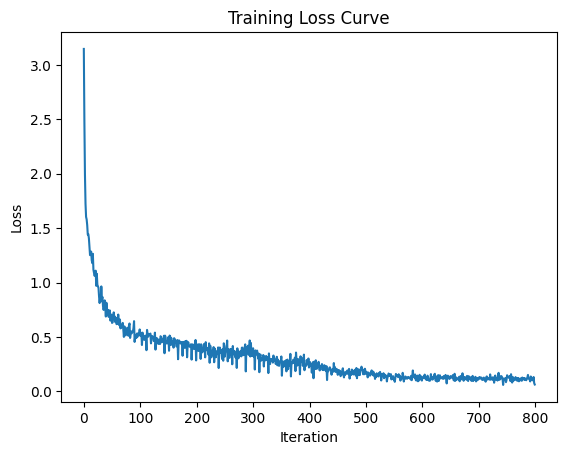

In [7]:
# Initialize the model with hyperparameters
my_model = EmbeddingLSTM(
    num_pc,
    num_delta_in,
    num_output_next,
    hparams["embed_dim"],
    hparams["hidden_dim"],
    topPredNum=hparams["topPredNum"],
    num_layers=hparams["num_layers"],
    dropout=hparams["dropout"]
)

# Prepare for training
train_loss = []
my_model = my_model.to(device)
optimizer = torch.optim.Adam(my_model.parameters(), lr=hparams["learning_rate"])

# Start training
for epoch in range(hparams["epochs"]):
    # Switch to training mode
    my_model.train()
    lstm_state = None
    for idx, batch in enumerate(train_iter):
        batch = [ds.to(device) for ds in batch]
        inputs = batch[:-1]
        targets = batch[-1]
        _, lstm_state, batch_loss = my_model(inputs, lstm_state, targets)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        train_loss.append(float(batch_loss.detach()))
        print(f"Epoch {epoch + 1}, Iteration {idx + 1}, Loss: {train_loss[-1]:.8f}")
        lstm_state = tuple([s.detach() for s in lstm_state])

# Plot the training loss curve
plt.plot(train_loss)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Validate the model

In [8]:
def validate_model(network, data_iterator, relevant_keys, computing_device="cpu", initial_state=None):
    network.eval()

    accuracy_metrics = [process_batch(i, batch_data, network, computing_device, initial_state, relevant_keys) 
                        for i, batch_data in enumerate(data_iterator)]

    average_accuracy = torch.tensor(accuracy_metrics).mean()
    print("Average Validation Accuracy: {:.4f}".format(average_accuracy))

def process_batch(batch_index, batch_data, network, device, state, keys):
    print(f"Processing batch {batch_index}")

    batch_data = [item.to(device) for item in batch_data]
    input_data = batch_data[:-1]
    labels = batch_data[-1]

    predictions, state = network.predict(input_data, state)

    accuracy = compute_accuracy(predictions, labels, keys)

    return accuracy

def compute_accuracy(predictions, labels, keys):
    combined_data = list(zip(labels, predictions))
    count_correct = sum([1 for label, predicted in combined_data 
                         if label.item() in keys and label in predicted])
    
    return count_correct / len(labels)

validate_model(my_model, test_iter, target_keys, computing_device="mps")


Processing batch 0
Processing batch 1
Processing batch 2
Average Validation Accuracy: 0.8579
